In [3]:
!pip install geffnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [1]:
import os
import glob
import cv2
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader,Dataset
import geffnet

PATH_MODEL = '../input/rainforestmodel'
PATH_SUBMIT = './'
PATH_CSV = '../input/rfcx-species-audio-detection/'

In [4]:
def mono_to_color(X: np.ndarray,
                  mean=None,
                  std=None,
                  norm_max=None,
                  norm_min=None,
                  eps=1e-6):
    """
    Code from https://www.kaggle.com/daisukelab/creating-fat2019-preprocessed-data
    """
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V


class RFDataset_test(Dataset):
    """
    .npy cut by 6sec one file have shape(10, *, *)    
    """

    def __init__(self, size, transform = None):
        p1 = glob.glob('../input/sr48power2mel260-p1/test_img/test/*.npy')
        p2 = glob.glob('../input/sr48power2mel260-p2/test_img/test/*.npy')
        p1.extend(p2)
        self.p1 = p1        
        self.size = size
        self.transform = transform
        
    
    def __len__(self):        
        return len(self.p1) 
    
    def __getitem__(self, index):
        temp = []       
       
        name = self.p1[index]          
        name_file = os.path.basename(name)
        img = np.load(name)
  
        if self.transform is not None:
            pass

        for i in range(len(img)):
            image = mono_to_color(img[i]) 
            if self.size is not None:
                image = cv2.resize(image, (224, self.size))
            image = image / 255.0
            image = image.transpose(2, 0, 1).astype(np.float32) 
            temp.append(image)        
        return torch.tensor(temp).float(), name_file.split('.')[0]

    
class EffB3(nn.Module):

  def __init__(self):
    super(EffB3, self).__init__()
    self.model = geffnet.create_model('tf_efficientnet_lite4', pretrained=True) 
    in_ch = self.model.classifier.in_features #1536
    self.myfc = nn.Sequential(nn.Linear(in_ch, 24))
    self.model.classifier = nn.Identity()   
      
  def extract(self, x):        
    x = self.model(x)        
    return x
      
  def forward(self, x):    
    if len(torch.squeeze(x).shape) == 4:
        x = torch.squeeze(x)
    else:
        x
    bs, _, _, _ = x.shape    
    x = self.extract(x)     
    # x = x.view(bs, -1)   
    x = self.myfc(x)
    return x 

# add layers

# sigmoid = torch.nn.Sigmoid()
# class Swish(torch.autograd.Function):
#     @staticmethod
#     def forward(ctx, i):
#         result = i * sigmoid(i)
#         ctx.save_for_backward(i)
#         return result
#     @staticmethod
#     def backward(ctx, grad_output):
#         i = ctx.saved_tensors[0]
#         sigmoid_i = sigmoid(i)
#         return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))
# swish = Swish.apply

# class Swish_module(nn.Module):
#     def forward(self, x):
#         return swish(x)
    
# swish_layer = Swish_module()

    
# class EffB3(nn.Module):

#   def __init__(self):
#     super(EffB3, self).__init__()
#     self.model = geffnet.create_model('tf_efficientnet_lite4', pretrained=True) 
#     self.model.global_pool = nn.AdaptiveAvgPool2d((1,1)) 
# #     self.model.global_pool  = nn.AdaptiveMaxPool2d((1,1))
#     in_ch = self.model.classifier.in_features #1536
#     self.myfc = nn.Sequential(
#         nn.Dropout(0.17418),
#         nn.Linear(in_ch, 785),
#         nn.BatchNorm1d(785),
# #         nn.ReLU(),
#         Swish_module(),
#         nn.Dropout(0.12), 
        
#         nn.Linear(785, 1038),
#         nn.BatchNorm1d(1038),
# #         nn.ReLU(),
#         Swish_module(),
#         nn.Dropout(0.3763722),       
#         nn.Linear(1038, 24)
#     )   
    
#     self.model.classifier = nn.Identity()   
      
#   def extract(self, x):        
#     x = self.model(x)        
#     return x
      
#   def forward(self, x):    
#     if len(torch.squeeze(x).shape) == 4:
#         x = torch.squeeze(x)
#     else:
#         x
#     bs, _, _, _ = x.shape    
#     x = self.extract(x)     
#     # x = x.view(bs, -1)   
#     x = self.myfc(x)
#     return x

(1992, '6612d3ab9')

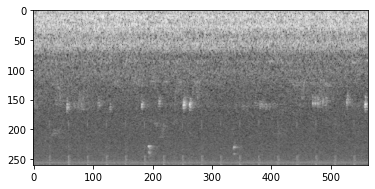

In [5]:
d = RFDataset_test(size = None)
img, name = d[1991]
plt.imshow(np.transpose(img[2], (1,2,0)))
d.__len__(), name

In [6]:
def main():
    #v2
    sub2 = pd.read_csv(os.path.join(PATH_CSV, 'sample_submission.csv'))
    sub2 = sub2.set_index('recording_id')
    sub2 *= 0 
    test_dataset = RFDataset_test(size = None)
    test_loader = DataLoader(test_dataset, batch_size=1, num_workers=1)
    # loads model
    for f in range(5):
        print('Fold: ', f + 1)
        model = EffB3()
        kernel_type = type(model).__name__
        model_type = os.path.join(PATH_MODEL, f'{kernel_type}_best_fold_{f}.pth')      
        print(f'Loads model: {model_type}')
        model = model.to(device)
        model.load_state_dict(torch.load(model_type), strict=True)
        model.eval()

        # models.append(model)
        with torch.no_grad():
            bar = tqdm(test_loader)
            for (img, name) in bar: # name (name, )
                img = img.to(device) 
                for i in range(img.shape[1]):
                    y_ = model(torch.unsqueeze(img[0][i], 0))                     
                    prob2 = torch.max(nn.Sigmoid()(y_), dim=0)[0]
                    pred2  =prob2.detach().cpu().numpy()           
                    sub2.loc[name[0]] += pred2                 
                
    return sub2.reset_index(drop=False)

In [ ]:
device = torch.device('cuda')
s2 = main()
s2.to_csv('s2.csv', index = False)